# Time Series with RNN

## Fill the cells marked with # TODO

** Import numpy pandas and matplotlib **

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the crop.csv file and set index_col='Month' **

In [0]:
# TODO
crop = pd.read_csv("crop.csv", index_col="Month")


** Check out the head of the dataframe**

In [0]:
crop.head()

,Crop
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

In [0]:
crop.index = pd.to_datetime(crop.index)

** Plot out the time series data. **

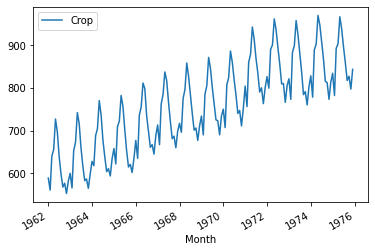

In [0]:
crop.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [0]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Crop    168 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [0]:
train_set = crop.iloc[:-13, :]

In [0]:
test_set = crop.iloc[-13:, :]

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
train_scaled = scaler.fit_transform(train_set)

In [0]:
test_scaled = scaler.transform(test_set)
print(test_scaled.shape)

(13, 1)


## Batch Function

** We'll need a function that can feed batches of the training data. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [0]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    data = np.zeros(shape=(batch_size, steps + 1, 1))
    for i in range(batch_size):
      # STEP 1: Use np.random.randint to set a random starting point index for the batch.
      # Remember that each batch needs have the same number of steps in it.
      # This means you should limit the starting point to len(data)-steps
      index = np.random.randint(0, training_data.shape[0] - steps - 1)
      # STEP 2: Now that you have a starting index you'll need to index the data from
      # the random start to random start + steps. Then reshape this data to be (1,steps)
      data[i, :, :] = np.reshape(training_data[index:index+steps+1, :], newshape=(1, steps+1, 1))
      # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
      # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
      # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)
    return data[:, :-1, :], data[:, 1:, :]
    
a, b = next_batch(train_scaled, 2, 12)
print(a.shape)
print(b.shape)

(2, 12, 1)
(2, 12, 1)


## Setting Up The RNN Model

** Import TensorFlow **

In [0]:
%tensorflow_version 1.x" before "import tensorflow
import tensorflow as tf
from tensorflow.contrib import rnn

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x" before "import tensorflow`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


### The Constants

** Define the constants in a single cell. You'll need the following (you can change some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [0]:
INPUT_NUMBER = 1
TIME_STEPS_NUMBER = 12
NEURONS_PER_LAYER_NUMBER = 100
OUTPUTS_NUMBER = 1
LR = 0.003
TRAIN_ITERATION_NUMBER = 4000
BATCH_SIZE = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps,num_inputs] and [None, num_time_steps, num_outputs].**  

In [0]:
X = tf.placeholder(tf.float32, shape=[None, TIME_STEPS_NUMBER, INPUT_NUMBER], name="input_series")
y = tf.placeholder(tf.float32, shape=[None, TIME_STEPS_NUMBER, OUTPUTS_NUMBER], name="output_value")

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (Hint: use an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [0]:
CELL_TYPE = "Multi_3LSTM"

if CELL_TYPE is "RNN":
  lstm_cell = rnn.OutputProjectionWrapper(rnn.BasicRNNCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER)
elif CELL_TYPE is "LSTM":
  lstm_cell = rnn.OutputProjectionWrapper(rnn.BasicLSTMCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER)
elif CELL_TYPE is "GRU":
  lstm_cell = rnn.OutputProjectionWrapper(rnn.GRUCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER)
elif  "Multi" in CELL_TYPE:
  cells = []
  cells.append(rnn.OutputProjectionWrapper(rnn.BasicLSTMCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER))
  cells.append(rnn.OutputProjectionWrapper(rnn.BasicLSTMCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER))
  cells.append(rnn.OutputProjectionWrapper(rnn.BasicLSTMCell(NEURONS_PER_LAYER_NUMBER, activation=tf.nn.relu), output_size=OUTPUTS_NUMBER))


  lstm_cell = rnn.MultiRNNCell(cells)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [0]:
outputs, states = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 12, 1) dtype=float32>

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [0]:
loss = tf.reduce_mean(tf.squared_difference(outputs, y))
optimizer = tf.train.AdamOptimizer(learning_rate=LR)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [0]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() to save your model after training. **

In [0]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. **

In [0]:
from time import time
train_losses = []
validation_losses = []

In [0]:
with tf.Session() as sess:
    sess.run(init)
    
    # TODO
    for iteration in range(TRAIN_ITERATION_NUMBER):
      start_time = time()
      x_batch, y_batch = next_batch(train_scaled, BATCH_SIZE, TIME_STEPS_NUMBER)
      _, train_loss = sess.run([train, loss], feed_dict={ X: x_batch, y: y_batch })
      eval_time = time() - start_time
      train_losses.append(train_loss)
      #evaluate validation loss
      if iteration % 100 == 0:
        print("Training loss in iteration {}: {}, Elapsed Time:{}".format(iteration, train_loss, eval_time))
        test_data = np.reshape(test_scaled, newshape=(1, -1, 1))
        val_loss = sess.run(loss, feed_dict={X: test_data[:, :-1,: ], y: test_data[:, 1:,: ]})
        validation_losses.append(val_loss)
        print("Validation loss in iteration {}: {}".format(iteration, val_loss))
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

Training loss in iteration 0: 0.2949942648410797, Elapsed Time:0.362656831741333
Validation loss in iteration 0: 0.5522481799125671
Training loss in iteration 100: 0.08017227798700333, Elapsed Time:0.008911609649658203
Validation loss in iteration 100: 0.10293108224868774
Training loss in iteration 200: 0.06323610991239548, Elapsed Time:0.00946187973022461
Validation loss in iteration 200: 0.07138416916131973
Training loss in iteration 300: 0.0275629460811615, Elapsed Time:0.009696006774902344
Validation loss in iteration 300: 0.04450118914246559
Training loss in iteration 400: 0.0559750534594059, Elapsed Time:0.009134292602539062
Validation loss in iteration 400: 0.04784320667386055
Training loss in iteration 500: 0.028444068506360054, Elapsed Time:0.008472681045532227
Validation loss in iteration 500: 0.04188406094908714
Training loss in iteration 600: 0.046953875571489334, Elapsed Time:0.008944511413574219
Validation loss in iteration 600: 0.05190838873386383
Training loss in iterat

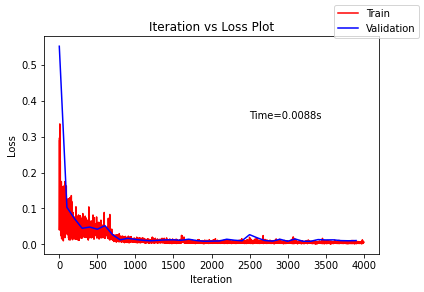

In [0]:
fig = plt.figure()
x_axis_train = np.arange(0, len(train_losses))
plt.plot(x_axis_train, train_losses, 'r', label="Train")
x_axis_validation = [(i*100) for i in range(len(validation_losses))]
plt.plot(x_axis_validation, validation_losses, 'b',  label="Validation")
fig.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Loss Plot")
plt.text(2500, 0.35, "Time={:.2}s".format(eval_time))
plt.show()
'''
import os
if not os.path.exists("output"):
    os.makedirs("output")
'''
#fig.savefig("output/{}_Loss.png".format(CELL_TYPE))

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [0]:
test_set

,Crop
Month,
1974-12-01 01:00:00,813.0
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our predicted 12 months to our actual true historical values from the test set! **

# Prediction Session

### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to predict 12 steps is a big ask, and technically not what it was trained to do! Think of this more as predicting new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of data set)

** Fill out the session code below to predict 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. 

In [0]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")
    
    # Create a numpy array for your predictive seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array

    #evaluate validation loss
    train_seed, valid_loss = sess.run([outputs, loss], feed_dict={X: np.reshape(train_scaled[-TIME_STEPS_NUMBER:], newshape=(BATCH_SIZE, -1, 1)), y: np.reshape(test_scaled[:-1], newshape=(BATCH_SIZE, -1, 1))})


INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [0]:
train_seed

array([[[0.59922564],
        [0.6391917 ],
        [0.51879203],
        [0.76312375],
        [0.97068095],
        [0.8574726 ],
        [0.83694094],
        [0.7339664 ],
        [0.6387445 ],
        [0.6220431 ],
        [0.5382649 ],
        [0.6209597 ]]], dtype=float32)

** Grab the portion of the results that are the predicted values and apply inverse_transform on them to turn them back into crop production value units. Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [0]:
results = scaler.inverse_transform(np.array(train_seed).reshape(12,1))

[[802.27783]
 [818.90375]
 [768.81744]
 [870.4595 ]
 [956.8032 ]
 [909.7086 ]
 [901.1674 ]
 [858.32996]
 [818.71765]
 [811.7699 ]
 [776.91815]
 [811.3192 ]]


** Create a new column on the test_set called "Prediction" and set it equal to the prediction results. You may get a warning about this, feel free to ignore it.**

In [0]:
test_set = test_set[:-1]


In [0]:
test_set["Prediction"] = results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [0]:
test_set

,Crop,Prediction
Month,,
1974-12-01 01:00:00,813.0,802.277832
1975-01-01 01:00:00,834.0,818.903748
1975-02-01 01:00:00,782.0,768.817444
1975-03-01 01:00:00,892.0,870.459473
1975-04-01 01:00:00,903.0,956.803223
1975-05-01 01:00:00,966.0,909.708618
1975-06-01 01:00:00,937.0,901.167419
1975-07-01 01:00:00,896.0,858.329956
1975-08-01 01:00:00,858.0,818.717651


In [0]:
# compute the mean absolute error
sum = 0
for i in range(len(test_set)):
  sum += abs(test_set.iloc[i, 1] - test_set.iloc[i, 0])
mae = sum/len(test_set)

** Plot out the two columns for comparison. **

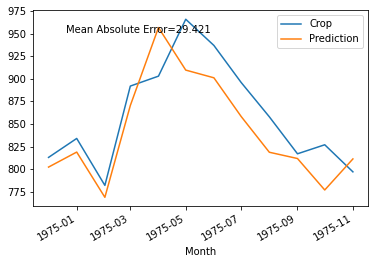

In [0]:
fig = test_set.plot().get_figure()
plt.figtext(0.2, 0.8, "Mean Absolute Error={:.5}".format(mae))
#fig.savefig("output/{}_Prediction.png".format(CELL_TYPE))
plt.show()

In [0]:
!zip -r /content/file.zip /content/output

updating: content/output/ (stored 0%)
updating: content/output/Multi_3LSTM_Loss.png (deflated 7%)
updating: content/output/outputs.zip (stored 0%)
updating: content/output/GRU_Prediction.png (deflated 4%)
updating: content/output/RNN_Loss.png (deflated 8%)
updating: content/output/Multi_3GRU_Prediction.png (deflated 4%)
updating: content/output/LSTM_Prediction.png (deflated 4%)
updating: content/output/Multi_3LSTM_Prediction.png (deflated 4%)
updating: content/output/Multi_3RNN_Prediction.png (deflated 4%)
updating: content/output/RNN_Prediction.png (deflated 4%)
updating: content/output/LSTM_Loss.png (deflated 8%)
updating: content/output/Multi_3RNN_Loss.png (deflated 7%)
updating: content/output/Multi_3GRU_Loss.png (deflated 7%)
updating: content/output/GRU_Loss.png (deflated 7%)
